In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Normalization,Dense,InputLayer
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv("uber.csv", delimiter=",")
# numpy_data = data.to_numpy()
df = pd.DataFrame(data)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['is_weekend'] = df['pickup_datetime'].dt.dayofweek >= 5

# Encode hour of the day with sine and cosine
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)

# Encode day of the week with sine and cosine
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Encode month with sine and cosine
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Drop the original hour_of_day, day_of_week, and month columns
df = df.drop(['pickup_datetime', 'hour_of_day', 'day_of_week', 'month'], axis=1)
df.dropna()
print(df.head())
df.shape
# Convert the DataFrame to a NumPy array




# sns.pairplot(data[['fare_amount','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','passenger_count']])

   Unnamed: 0      key  fare_amount  pickup_longitude  pickup_latitude  \
0    24238194  52:06.0          7.5        -73.999817        40.738354   
1    27835199  04:56.0          7.7        -73.994355        40.728225   
2    44984355  45:00.0         12.9        -74.005043        40.740770   
3    25894730  22:21.0          5.3        -73.976124        40.790844   
4    17610152  47:00.0         16.0        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  is_weekend  hour_sin  \
0         -73.999512         40.723217                1       False -0.965926   
1         -73.994710         40.750325                1       False -0.866025   
2         -73.962565         40.772647                1       False -0.707107   
3         -73.965316         40.803349                3       False  0.866025   
4         -73.973082         40.761247                5       False -0.965926   

   hour_cos   day_sin   day_cos     month_sin  month_cos  
0  0.2588

(200000, 15)

In [20]:

df = df.sample(frac=1, random_state=43).reset_index(drop=True)
df.drop('key',axis=1,inplace=True)

df.shape



(200000, 14)

In [21]:

# df = df.drop('key',axis=1)
# print(df.head())
tensor_data = tf.convert_to_tensor(df,dtype=tf.float32)
tensor_data = tf.random.shuffle(tensor_data)



In [22]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(tensor_data)

#x and y dataset
X = tensor_data[:,2:]
y = tensor_data[:,-2]
y = tf.reshape(y,[-1,1])

#computing size
TRAIN_SIZE = int(TRAIN_RATIO * DATASET_SIZE)
VAL_SIZE = int(VAL_RATIO * DATASET_SIZE)
TEST_SIZE = int(TEST_RATIO * DATASET_SIZE)

#splitting data

X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
print(y_test.shape)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)


(20000, 1)


In [58]:
#Model Figure
print(X_train.shape)
normalizer = Normalization()
normalizer.adapt(X_train)

(160000, 12)


In [78]:
#Model Figure

model = tf.keras.Sequential([
    InputLayer(input_shape=(12,)),
    normalizer,
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(1)
])
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_13 (Normaliz  (None, 12)                25        
 ation)                                                          
                                                                 
 dense_44 (Dense)            (None, 64)                832       
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dense_46 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5082 (19.86 KB)
Trainable params: 5057 (19.75 KB)
Non-trainable params: 25 (104.00 Byte)
_________________________________________________________________


In [79]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_absolute_error',
              metrics = RootMeanSquaredError())

#epoch refers to the amount of times graident of descent is perform
#verbose = 0 means no output
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,verbose=1)

Epoch 1/10
5000/5000 [==============================] - 21s 4ms/step - loss: 0.0205 - root_mean_squared_error: 0.2741 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0213
Epoch 2/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0086 - root_mean_squared_error: 0.0541 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0297
Epoch 3/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0064 - root_mean_squared_error: 0.0553 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0406
Epoch 4/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0890 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0182
Epoch 5/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0568 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0319
Epoch 6/10
5000/5000 [==============================] - 17s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0518 - val_l

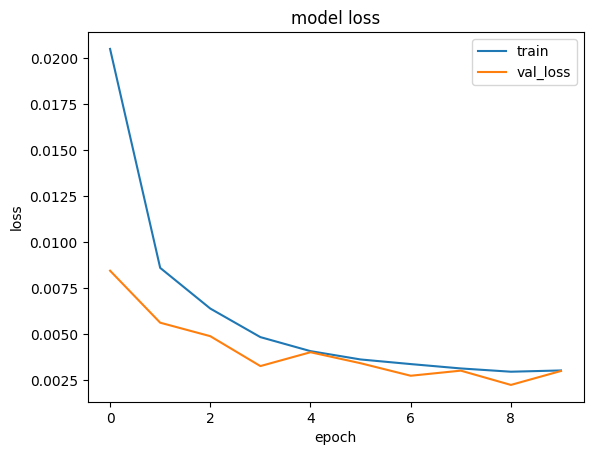

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val_loss'])
plt.show()


In [81]:
model.evaluate(X_test ,y_test)

625/625 [==============================] - 1s 2ms/step - loss: nan - root_mean_squared_error: nan


[nan, nan]

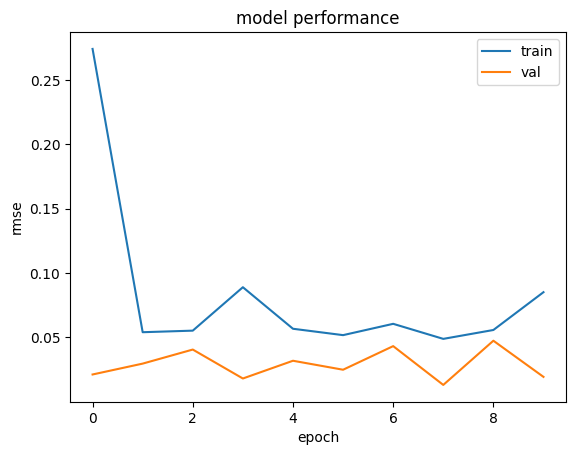

In [83]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model performance')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [99]:
model.predict(tf.expand_dims(X_test[30], axis = 0 ))


1/1 [==============================] - 0s 17ms/step


array([[-0.9573089]], dtype=float32)

In [98]:
print(y_test[30])

tf.Tensor([[-1.]], shape=(1, 1), dtype=float32)


In [93]:
y_pred = list(model.predict(X_test)[:,0])

y_test = tf.expand_dims(y_test, axis = -1 )
print(y_test.shape)

y_true = list(y_test[:,0].numpy())

625/625 [==============================] - 1s 2ms/step
(20000, 1, 1)


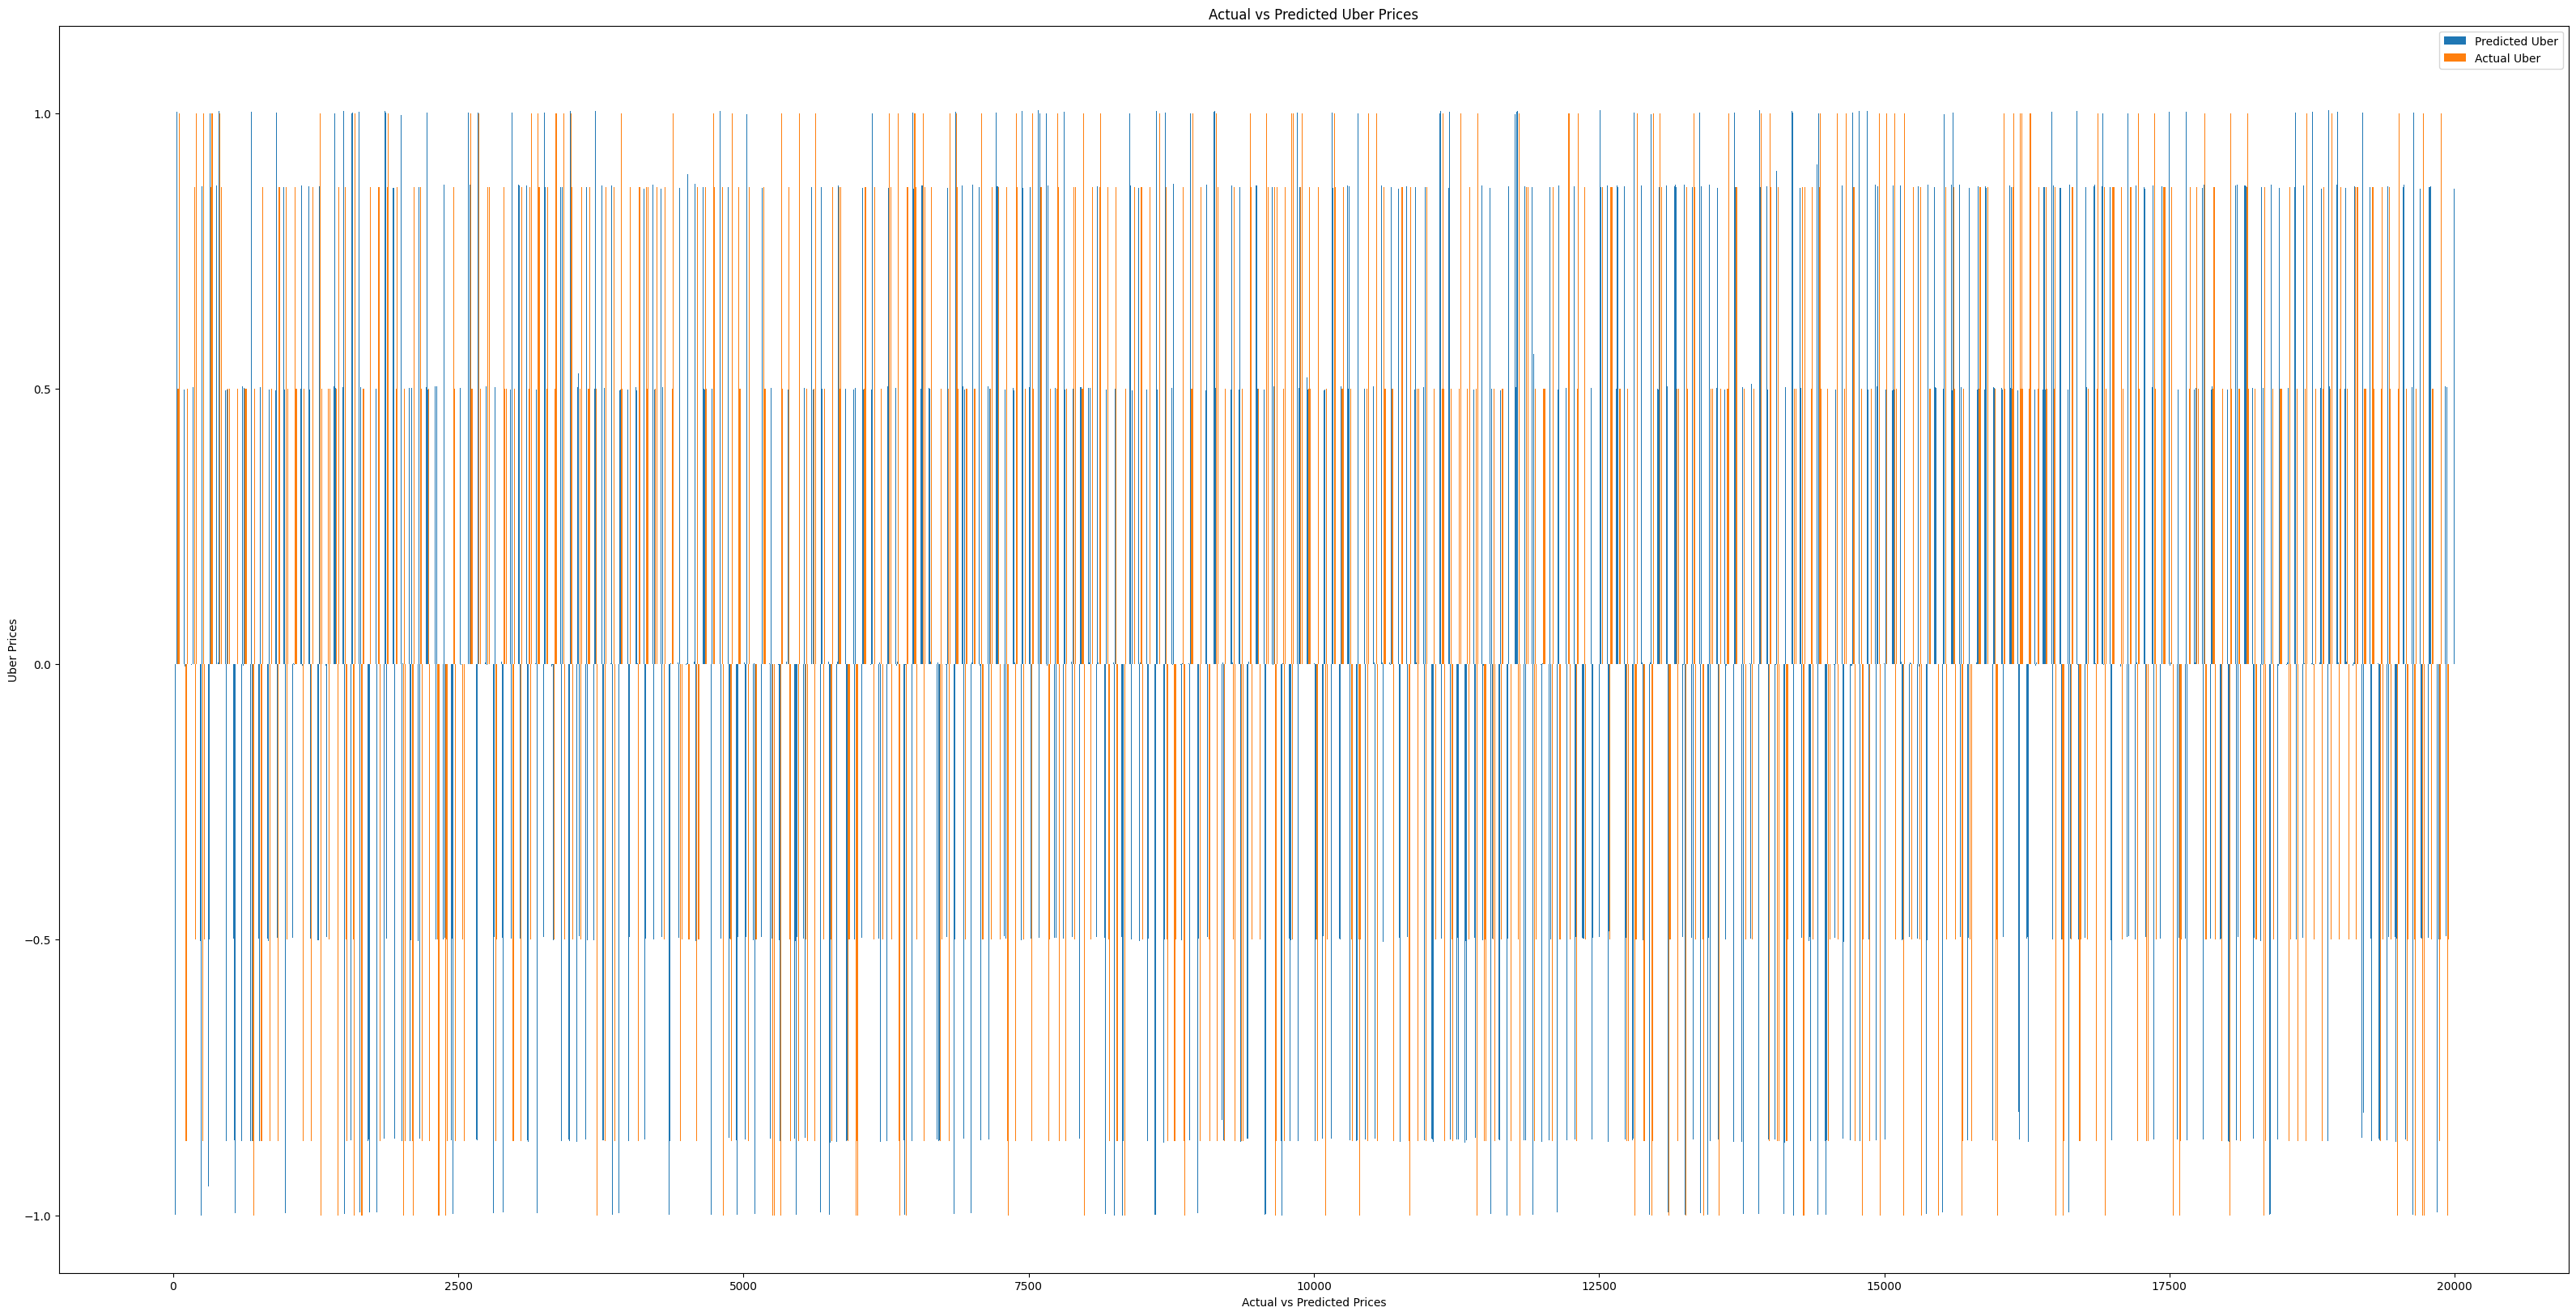

In [95]:
ind = np.arange(20000)
plt.figure(figsize=(40,20))
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

width = 0.3

plt.bar(ind, y_pred, width, label='Predicted Uber')
plt.bar(ind + width, y_true, width, label='Actual Uber')

plt.xlabel('Actual vs Predicted Prices')
plt.ylabel('Uber Prices')
plt.title('Actual vs Predicted Uber Prices')
plt.legend()

plt.show()